### Setup

In [2]:
import os
import cv2
import math
import torch
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units
from PIL import Image
from config_loader import load_config
from scipy.spatial import distance


In [3]:
paths = load_config('config/paths.json')

In [4]:
template_filenames = ["STRIPE82-0007-*",
                      "STRIPE82-0008-*",
                      "STRIPE82-0009-*",
                      "STRIPE82-0010-*",
                      "STRIPE82-0011-*",
                      "STRIPE82-0012-*",
                      "STRIPE82-0013-*",
                      "STRIPE82-0014-*",
                      "STRIPE82-0015-*",
                      "STRIPE82-0016-*",
                      "STRIPE82-0017-*",
                      "STRIPE82-0018-*",
                      "STRIPE82-0019-*",
                      "STRIPE82-0020-*"]

VAL_FIELDS = ["STRIPE82-0015"]

TEST_FIELDS = ["STRIPE82-0019"]

bands_to_zps = {'g':"ZP_G",
                'J0515': "ZP_F515", 
                'r': "ZP_R",
                'i':"ZP_I",
                'J0861': "ZP_F861",
                'z': "ZP_Z",
                'J0660': "ZP_F660",
                'u': "ZP_U",
                'J0378': "ZP_F378",
                'J0395': "ZP_F395", 
                'J0410': "ZP_F410",
                'J0430': "ZP_F430"
}

fits_data_size = 9088
tile_size = 128

### Crop and calibrate

In [ ]:
def crop_and_calibrate(in_path, out_path, final_size, bands_to_zps, zps_table):
    file = fits.open(in_path)
    cut = (11000 - final_size) // 2
    img = file[1].data[cut:-cut, cut:-cut].astype(np.float32)

    filename_split = re.split('[/]', str(in_path))
    field = filename_split[-1][0:13]
    filename_split = re.split('[-]', str(filename_split))
    band = filename_split[-1]
    ps_sqr = 0.55 * 0.55
    zp_value = float(zps_table[zps_table["Field"]==field][bands_to_zps[band]].iloc[0])
    calibration_value = (10 ** (5 - 0.4 * zp_value) / (ps_sqr))

    img = torch.from_numpy(img)
    dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    img.to(dev)
    img = torch.mul(img, calibration_value)

    img = img.cpu().numpy()
    file[1].data = img
    file.writeto(out_path, overwrite=False)
    
    file.close()

    return

zps_table = pd.read_csv(paths['zps_path'])

for filename in template_filenames:
    for band in bands_to_zps.keys():
        filename = filename.split("-")
        filename[-1] = band + ".fits"
        filename = '-'.join(filename)
        crop_and_calibrate(paths['data_path'] + "/" + filename, paths['objdet_scratch'] + "/" + filename, fits_data_size, bands_to_zps, zps_table)

### Organize FITS files in tiled PNG images and label the objects

In [299]:
def pix2coord(wcs_obj,coords:iter)->tuple:
    """
    returns the ra, dec location given a pixel pair
    """
    coord = wcs_obj.pixel_to_world(coords[0],coords[1])
    
    return round(coord.ra.value,6),round(coord.dec.value,6)

def coord2pix(wcs_obj,coords:iter)->tuple:
    """
    returns the pixel location given a pair RA, DEC
    """
    coords_t = SkyCoord(ra = coords[0]*units.degree, dec = coords[1]*units.degree)
    pixels = wcs_obj.world_to_pixel(coords_t)
    return int(np.round(pixels[0])), int(np.round(pixels[1]))

def verify_obj(blobs_dog, coordinate, X_tile, Y_tile, obj, tile_size):
    X, Y = coordinate[0] - tile_size * X_tile, coordinate[1] - tile_size * Y_tile
    for p in blobs_dog:
        y, x, r = p
        if distance.euclidean((X, Y), (x, y)) <= 3*r:
            x_norm = X / tile_size
            y_norm = Y / tile_size

            obj_size_norm = obj.fwhm_n * 5 / tile_size

            obj_size_norm = 0.9999 if obj_size_norm >= 1.0 else obj_size_norm

            return f"{obj['class']} {x_norm} {y_norm} {obj_size_norm} {obj_size_norm}\n"
        
    return ""

def label_and_save_tile(wcs_obj, field_name, img_path, label_path, objs, hdus, pixstart, pixstop, img_size, tile_size):
    if (objs.r_auto <= 13).any():
        return -1

    # [0] -> column; [1] -> row
    r = np.add.reduce(hdus[:6, pixstart[1]:pixstop[1], pixstart[0]:pixstop[0]])
    g = hdus[6, pixstart[1]:pixstop[1], pixstart[0]:pixstop[0]]
    b = np.add.reduce(hdus[6:, pixstart[1]:pixstop[1], pixstart[0]:pixstop[0]])
    img = np.array([r, g, b])

    img = np.clip(img, 0.0, np.max(img))
    min, max = np.min(img), np.max(img)
    if max - min <= 0.000001:
        print(field_name, X, Y)
        return 1
    else:
        img = (img - min) / (max - min)

    gray = 0.299*img[0, :, :] + 0.114*img[1, :, :] + 0.587*img[2, :, :]

    img = img.transpose(1, 2, 0)

    blobs_dog = ski.feature.blob_dog(gray, sigma_ratio=1.7, max_sigma=90, threshold=0.0245)
    if len(blobs_dog) >= 5:
        return -1
    
    blobs_dog[:, 2] = blobs_dog[:, 2] * math.sqrt(2)

    offset = (11000 - img_size) // 2

    X_tile = (pixstart[0]) // tile_size
    Y_tile = (pixstart[1]) // tile_size
    labels = ""
    for _, obj in objs.iterrows():
        if (obj.r_auto != 99 and obj.r_auto >= 21.5):
            pass

        pixels = coord2pix(wcs_obj, (obj.ra, obj.dec))
        X = pixels[0] - offset
        Y = pixels[1] - offset 

        if X >= img_size or Y >= img_size or X < 0 or Y < 0:
            pass

        coordinate = (X, Y)

        labels += verify_obj(blobs_dog, coordinate, X_tile, Y_tile, obj, tile_size)

    img = Image.fromarray((img * 255).astype(np.uint8)).convert('RGB')

    png_filename = field_name + "-" + str(X_tile) + "-" + str(Y_tile) + ".png"
    img.save(os.path.join(paths[img_path], png_filename))

    if labels != "":
        txt_filename = field_name + "-" + str(X_tile) + "-" + str(Y_tile) + ".txt"
        file = os.path.join(paths[label_path], txt_filename)
        if not os.path.exists(file):
            with open(file, "w") as f:
                f.write(labels)

    return 0

In [ ]:
img_size = 9088
tile_size = 128
offset = (11000 - img_size) // 2

for field in template_filenames:
    hdus = []
    for band in bands_to_zps.keys():
        filename = field.split("-")
        filename[-1] = band + ".fits"
        filename = '-'.join(filename)
        hdus.append(fits.open(paths['objdet_scratch'] + "/" + filename)[1].data)

    hdus = np.asarray(hdus)

    wcs_obj = WCS(fits.open(os.path.join(paths["objdet_scratch"], filename))[1].header)

    field_name = field[0:13]

    objs = pd.read_csv(os.path.join(paths['tables_path'], f"DR4-{field_name}-objs.csv"))
    objs = objs[np.logical_or(np.logical_or(objs['prob_qso'] > 0.55, objs['prob_star'] > 0.55), objs['prob_gal'] > 0.55)]
    objs = objs[objs['fwhm_n'] >= 0.2]

    if field_name in VAL_FIELDS:
        img_path = "val_img_path"
        label_path = "val_label_path"
    elif field_name in TEST_FIELDS:
        img_path = "test_img_path"
        label_path = "test_label_path"
    else:
        img_path = "train_img_path"
        label_path = "train_label_path"

    for X_tile in range(img_size // tile_size):
        for Y_tile in range(img_size // tile_size):
            x_1, x_2 = tile_size * X_tile + offset, tile_size * (X_tile + 1) + offset
            y_1, y_2 = tile_size * Y_tile + offset, tile_size * (Y_tile + 1) + offset

            x_start = np.max([x_1, x_2])
            x_stop = np.min([x_1, x_2])
            y_start = np.min([y_1, y_2])
            y_stop = np.max([y_1, y_2])

            p1, p2 = pix2coord(wcs_obj, (x_start, y_start)), pix2coord(wcs_obj, (x_stop, y_stop))
            tile_objs = objs.query(f"ra > {p1[0]} and ra < {p2[0]} and dec > {p1[1]} and dec < {p2[1]}")

            label_and_save_tile(wcs_obj, field_name, img_path, label_path, tile_objs, hdus, (x_1-offset, y_1-offset), (x_2-offset, y_2-offset), img_size, tile_size)

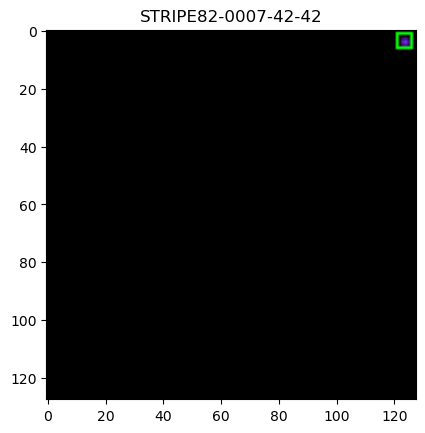

In [298]:
class_decode = ["quasar", "star", "galaxy"]

#field_name = "STRIPE82-0019"

if field_name in VAL_FIELDS:
    img_path = "val_img_path"
    label_path = "val_label_path"
elif field_name in TEST_FIELDS:
    img_path = "test_img_path"
    label_path = "test_label_path"
else:
    img_path = "train_img_path"
    label_path = "train_label_path"

#X_tile, Y_tile = 30, 29
filepref = f"{field_name}-{X_tile}-{Y_tile}"

image = cv2.imread(paths[img_path] + "/" + f"{filepref}.png")
with open(paths[label_path] + "/" + f"{filepref}.txt") as f:
    labels = f.readlines()
for label in labels:
    label = label.split(" ")
    X_start = int((float(label[1]) - float(label[3]) / 2) * tile_size)
    Y_start = int((float(label[2]) - float(label[3]) / 2) * tile_size)
    X_end = int((float(label[1]) + float(label[3]) / 2) * tile_size)
    Y_end = int((float(label[2]) + float(label[3]) / 2) * tile_size)
    obj_target = int(label[0])
    cv2.rectangle(image, (X_start, Y_start), (X_end, Y_end), (0,255,0), 1)
    cv2.putText(image, class_decode[obj_target], (X_start-3, Y_start-3), cv2.FONT_HERSHEY_SIMPLEX, 0.32, (0,255,0), 1)
plt.title(filepref)
plt.imshow(image);

### Data labeling (old)

In [ ]:
def coord2pix(wcs_obj,coords:iter)->tuple:
    """
    returns the pixel location given a pair RA, DEC
    """
    coords_t = SkyCoord(ra = coords[0]*units.degree, dec = coords[1]*units.degree)
    pixels = wcs_obj.world_to_pixel(coords_t)
    return int(np.round(pixels[0])), int(np.round(pixels[1]))

def label_obj(obj: pd.Series, wcs_obj: WCS, field: str, set: str, cropped_img_size = 9344, tile_size = 128):
    pixels = coord2pix(wcs_obj, (obj.ra, obj.dec))
    offset = (11000 - cropped_img_size) // 2

    X = pixels[0] - offset
    Y = pixels[1] - offset 

    if X >= cropped_img_size or Y >= cropped_img_size or X < 0 or Y < 0:
        return 1
    
    # x -> column; y -> row
    X_tile = X // tile_size
    Y_tile = Y // tile_size
    filename = field + '-' + str(X_tile) + '-' + str(Y_tile) + '.txt'

    x_norm = (X - tile_size * X_tile) / tile_size
    y_norm = (Y - tile_size * Y_tile) / tile_size

    obj_size_norm = obj.fwhm_n * 350 / tile_size

    obj_size_norm = 0.9999 if obj_size_norm >= 1.0 else obj_size_norm

    label = f"{obj['class']} {x_norm} {y_norm} {obj_size_norm} {obj_size_norm}\n"

    if set == "train":
        file = os.path.join(paths["train_label_path"], filename)
    elif set == "val":
        file = os.path.join(paths["val_label_path"], filename)
    else:
        file = os.path.join(paths["test_label_path"], filename)

    if not os.path.exists(file):
        with open(file, "w") as f:
            f.write(label)
    else:
        with open(file, "a") as f:
            f.write(label)

    return 0

for field in template_filenames:
    count = 0

    field_name = field[0:13]
    
    objs = pd.read_csv(os.path.join(paths['tables_path'], f"DR4-{field_name}-objs.csv"))
    fwhms = pd.read_csv(os.path.join(paths['tables_path'], f"DR4-{field_name}-fwhm_n.csv"))

    objs = objs[objs.id.str.contains(field_name)]
    fwhms = fwhms[fwhms.id.str.contains(field_name)]

    objs = objs[['id', 'ra', 'dec', 'class', 'prob_qso', 'prob_star', 'prob_gal']]
    objs = objs[np.logical_or(np.logical_or(objs['prob_qso'] > 0.75, objs['prob_star'] > 0.75), objs['prob_gal'] > 0.75)]

    fwhms = fwhms[['id', 'fwhm_n']]
    fwhms = fwhms[fwhms['fwhm_n'] > 0.8]

    objs = pd.merge(objs, fwhms, on='id')

    filename = list(field)
    filename[-6] = 'r' # placeholder
    filename = ''.join(filename)
    file = fits.open(os.path.join(paths["data_path"], filename))
    wcs_obj = WCS(file[1].header)

    if field_name in VAL_FIELDS:
        set = "val"
    elif field_name in TEST_FIELDS:
        set = "test"
    else:
        set = "train"

    for _, obj in objs.iterrows():
        count += label_obj(obj, wcs_obj, field_name, set, fits_data_size, tile_size)

    print(f"Objects out of the field {field}: {count}\n")